In [451]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib
import sklearn
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.semi_supervised import LabelSpreading

%matplotlib inline


# ## Data Preprocessing and Cleaning
We begin by importing the data and examining the columns.

In [492]:
data = pd.read_csv('dat/online_shoppers_intention.csv.gz', compression='gzip')
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [453]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

We can see that the data is composed of 12330 entries (rows), and 18 variables (columns). There are no missing values. The column 'Month' is a categorical variable that we will use to split the dataset, the columns `'Administrative'`, `'Informational'`, `'ProductRelated'`, `'Browser'`, `'OperatingSystems'` and `'Region'` are categorical numerical variables (discrete variables). The columns `'VisitorType'`, `'Weekend'` and the target variable `'Revenue'` are categorical variables (of Boolean type) that should be transformed to numerical variables before we can use them in our model (to be done later). The rest of the columns are numeric with continuous (float) values. The data needs no cleaning.

In [454]:
disc_cat_cols =  ['Administrative', 'Informational', 'ProductRelated', 'Browser', 'Region','OperatingSystems', 'TrafficType']
non_num_cat_cols = ['VisitorType', 'Weekend', 'Revenue', 'Month']
continuous_cols = ['Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues','SpecialDay']
len(disc_cat_cols) + len(non_num_cat_cols) + len(continuous_cols) == 18

True

## Data Exploration

### Univariate Analysis
For the numerical features, we compute and visualize the number of unique values.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'SpecialDay'),
  Text(1, 0, 'OperatingSystems'),
  Text(2, 0, 'Region'),
  Text(3, 0, 'Browser'),
  Text(4, 0, 'Informational'),
  Text(5, 0, 'TrafficType'),
  Text(6, 0, 'Administrative'),
  Text(7, 0, 'ProductRelated'),
  Text(8, 0, 'Informational_Duration'),
  Text(9, 0, 'BounceRates'),
  Text(10, 0, 'PageValues'),
  Text(11, 0, 'Administrative_Duration'),
  Text(12, 0, 'ExitRates'),
  Text(13, 0, 'ProductRelated_Duration')])

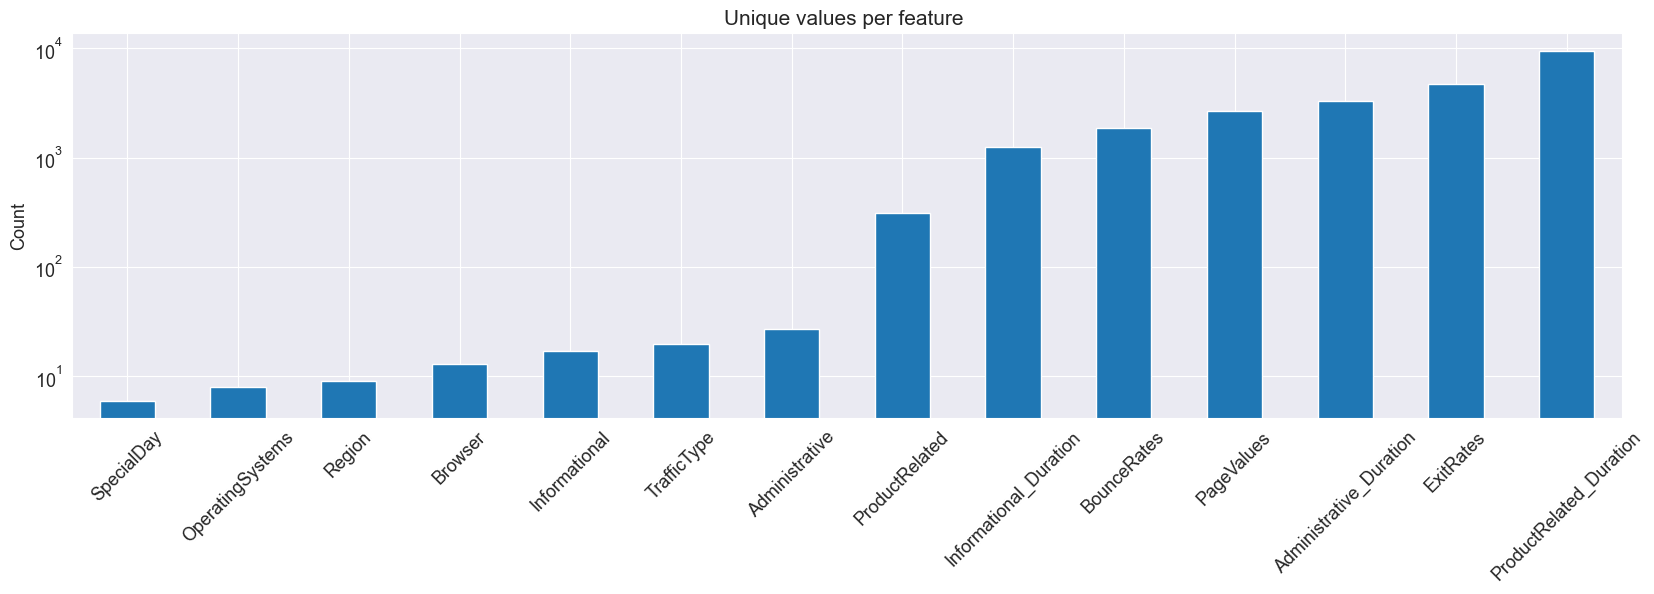

In [455]:
unique_values = data.select_dtypes(include="number").nunique().sort_values()
# Plot information with y-axis in log-scale
unique_values.plot.bar(logy=True, figsize=(20, 5))
plt.title('Unique values per feature ', fontsize=15)
plt.ylabel('Count', fontsize=13)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13, rotation = 45)

Next we compute some basic descriptive statistics of the numerical variables.

In [456]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Administrative,12330.0,2.315166,3.321784,0.0,0.000000,1.000000,4.000000,27.000000
Administrative_Duration,12330.0,80.818611,176.779107,0.0,0.000000,7.500000,93.256250,3398.750000
Informational,12330.0,0.503569,1.270156,0.0,0.000000,0.000000,0.000000,24.000000
Informational_Duration,12330.0,34.472398,140.749294,0.0,0.000000,0.000000,0.000000,2549.375000
ProductRelated,12330.0,31.731468,44.475503,0.0,7.000000,18.000000,38.000000,705.000000
ProductRelated_Duration,12330.0,1194.746220,1913.669288,0.0,184.137500,598.936905,1464.157214,63973.522230
BounceRates,12330.0,0.022191,0.048488,0.0,0.000000,0.003112,0.016813,0.200000
ExitRates,12330.0,0.043073,0.048597,0.0,0.014286,0.025156,0.050000,0.200000
PageValues,12330.0,5.889258,18.568437,0.0,0.000000,0.000000,0.000000,361.763742
SpecialDay,12330.0,0.061427,0.198917,0.0,0.000000,0.000000,0.000000,1.000000


We will now take a look at the distribution of the categorical variables:

(array([0, 1, 2]),
 [Text(0, 0, 'Returning_Visitor'),
  Text(1, 0, 'New_Visitor'),
  Text(2, 0, 'Other')])

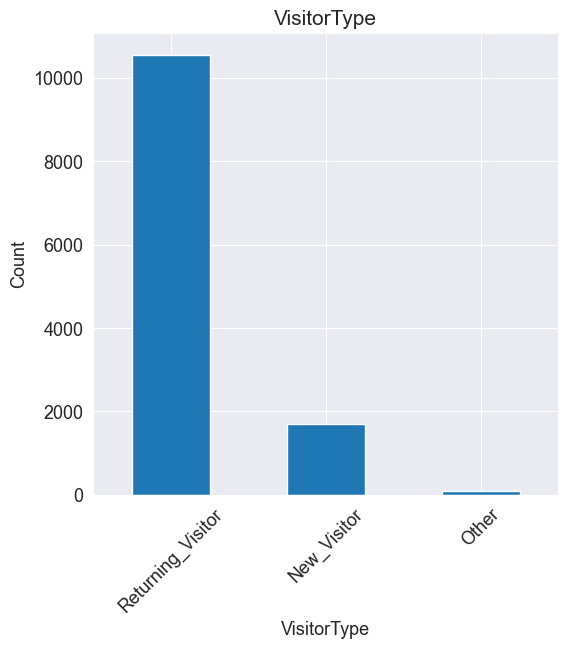

In [457]:
data['VisitorType'].value_counts().plot(kind='bar', figsize=(6,6))
plt.title('VisitorType', fontsize=15)
plt.xlabel('VisitorType', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13, rotation = 45)

`'VisitorType'` has three unique values, `'Returning_Visitor'`, `'New Visitor'` and `'Other'`. The Returning visitors are many times more present in the dataset. We will now visualize the distribution of the `'Weekend'` variable.

(array([0, 1]), [Text(0, 0, 'False'), Text(1, 0, 'True')])

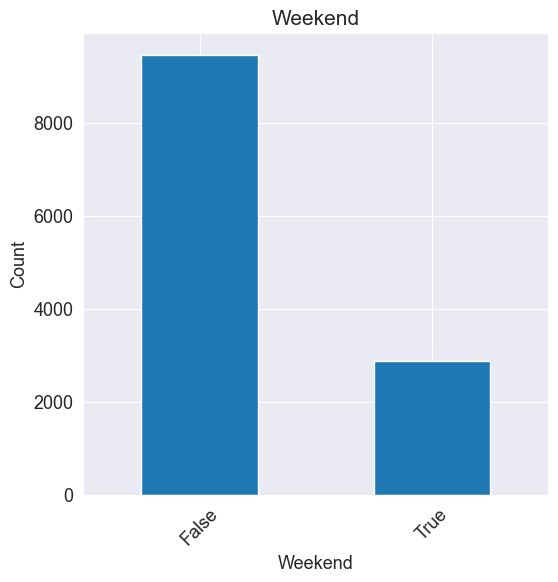

In [458]:
# Visualize the distribution of the 'Weekend' variable
data['Weekend'].value_counts().plot(kind='bar', figsize=(6,6))
plt.title('Weekend', fontsize=15)
plt.xlabel('Weekend', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13, rotation = 45)

 `'Weekend'` has two unique values, `'Weekend'` and `'Weekday'`. Here we see that most of the visitors access the website on weekdays.

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, '2'),
  Text(1, 0, '1'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '8'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '5')])

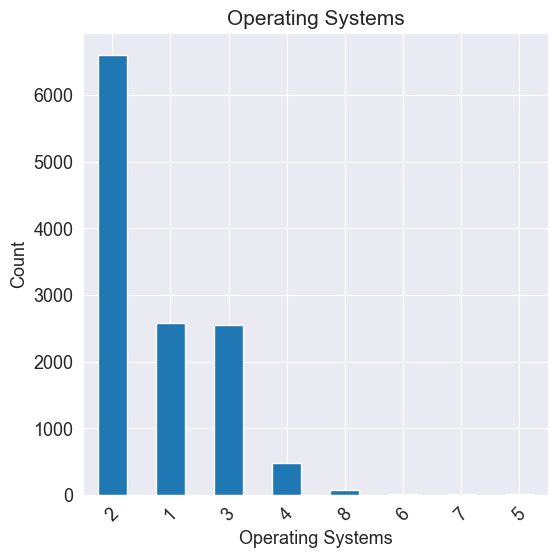

In [459]:
# Visualize the distribution of the 'OperatingSystems' variable

data['OperatingSystems'].value_counts().plot(kind='bar', figsize=(6,6))
plt.title('Operating Systems', fontsize=15 )
plt.title('Operating Systems', fontsize=15)
plt.xlabel('Operating Systems', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13, rotation = 45)

The operating system with the label `'2'` is the most frequent in the dataset and there are five operating systems with less than 10% of the visitors.
 We will now visualize the distribution of the `'Browser'` variable.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, '2'),
  Text(1, 0, '1'),
  Text(2, 0, '4'),
  Text(3, 0, '5'),
  Text(4, 0, '6'),
  Text(5, 0, '10'),
  Text(6, 0, '8'),
  Text(7, 0, '3'),
  Text(8, 0, '13'),
  Text(9, 0, '7'),
  Text(10, 0, '12'),
  Text(11, 0, '11'),
  Text(12, 0, '9')])

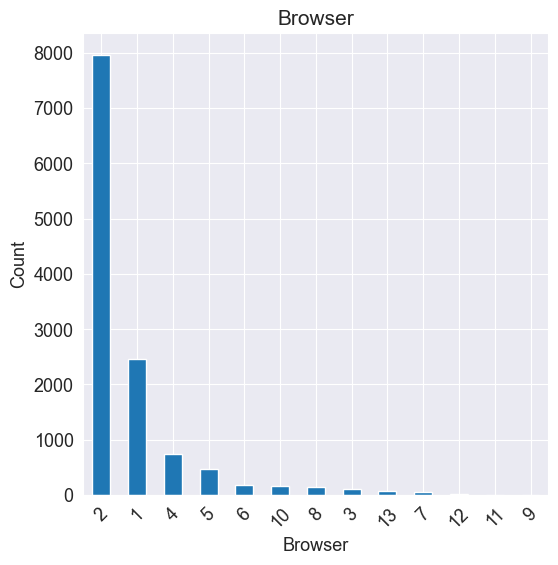

In [460]:
# Visualize the distribution of the 'Browser' variable
data['Browser'].value_counts().plot(kind='bar', figsize=(6,6))
plt.title('Browser', fontsize=15 )
plt.xlabel('Browser', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13, rotation = 45)

Here we see that the most frequent browser is the one labeled as '2' and there are 12 different browsers in the dataset.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'May'),
  Text(1, 0, 'Nov'),
  Text(2, 0, 'Mar'),
  Text(3, 0, 'Dec'),
  Text(4, 0, 'Oct'),
  Text(5, 0, 'Sep'),
  Text(6, 0, 'Aug'),
  Text(7, 0, 'Jul'),
  Text(8, 0, 'June'),
  Text(9, 0, 'Feb')])

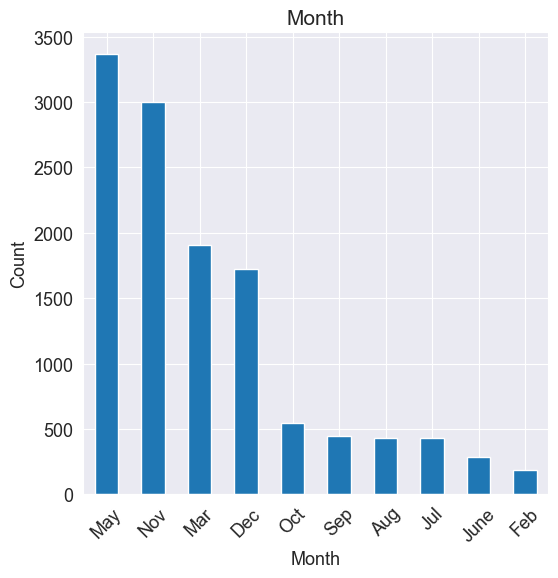

In [461]:
# Visualize the distribution of the 'Month' variable
data['Month'].value_counts().plot(kind='bar', figsize=(6,6))
plt.title('Month', fontsize=15 )
plt.xlabel('Month', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13, rotation = 45)

We also see that the data is imbalanced with respect to the `'Month'` variable.

array([[<AxesSubplot:title={'center':'Administrative'}>,
        <AxesSubplot:title={'center':'Informational'}>,
        <AxesSubplot:title={'center':'ProductRelated'}>],
       [<AxesSubplot:title={'center':'BounceRates'}>,
        <AxesSubplot:title={'center':'ExitRates'}>,
        <AxesSubplot:title={'center':'PageValues'}>],
       [<AxesSubplot:title={'center':'TrafficType'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

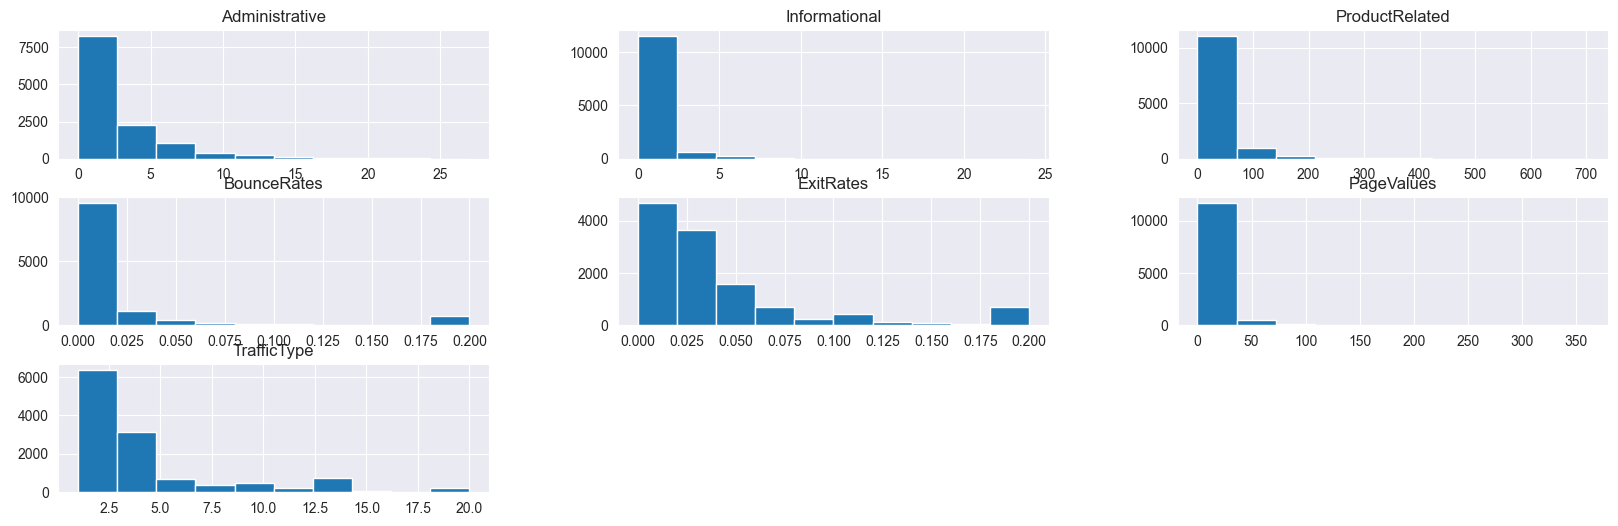

In [462]:
data2 = data[['Administrative', 'Informational', 'ProductRelated', 'BounceRates', 'ExitRates', 'PageValues','TrafficType']]
data2.hist(figsize=(20,6))

Similarly for the other categorical variables, the distribution is imbalanced and localized in only a few values. It appears that most of the categorical variables are exponentially distributed.

Finally we will visualize the distribution of the `'Revenue'` (target variable).

(array([0, 1]), [Text(0, 0, 'False'), Text(1, 0, 'True')])

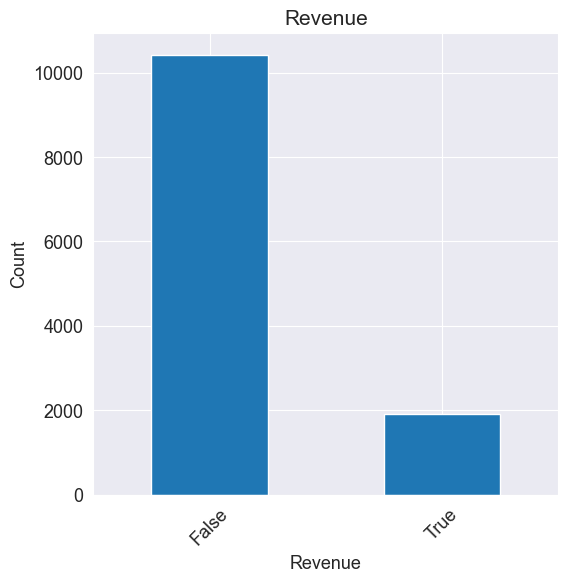

In [463]:
data['Revenue'].value_counts().plot(kind='bar', figsize=(6,6))
plt.title('Revenue', fontsize=15 )
plt.xlabel('Revenue', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13, rotation = 45)

In [464]:
data['Revenue'].value_counts()

print(f"The variable 'Revenue' has the value False for {data['Revenue'].value_counts()[False]/len(data['Revenue'])*100:.2f}% of the entries of the dataset.")

The variable 'Revenue' has the value False for 84.53% of the entries of the dataset.


## Bivariate Analysis and Feature Engineering

To begin our bivariate analysis we compute a correlation plot. Since this is only possible when the variables are numerical, we need to convert the categorical variables.
The categorical variables that only take a small number of numerical values should be one-hot encoded. There are also categorical variables that take a large number of discrete values, but these cannot be one-hot encoded because the dataset size would be too large. The month variable will only be used to split the dataset, so it can be converted using a label encoding. Since the values in the `'Month'` variable in the test and train sets do not overlap, we can drop this variable too from the train and test datasets (it will have no effect).

The `'Revenue'` variable will be used as the target variable, so it does not need to be converted.

We use the one hot encoding on the variables with a value count smaller or equal to 10.

In [465]:
# Convert the 'Month' variable to a label encoding and split the dataset into train and test sets
data.Month = data.Month.replace({'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'June':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12})
df_train = data[data['Month'] >= 6]
df_test = data[data['Month'] < 4]

X_train = df_train.drop(['Revenue'], axis=1).drop(['Month'], axis=1)
X_test = df_test.drop(['Revenue'], axis=1).drop(['Month'], axis=1)
y_train = df_train['Revenue']
y_test = df_test['Revenue']

X_train.shape, X_test.shape



((6875, 16), (2091, 16))

In [466]:
# One hot encoding of the categorical variables with few values
disc_cat_cols =  ['Administrative', 'Informational', 'ProductRelated', 'Browser', 'TrafficType']
ohe_cols = ['VisitorType', 'Weekend', 'OperatingSystems', 'Region']
#ohe_cols = disc_cat_cols + non_num_cat_cols[0:2]
numeric_cols = ['Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues','SpecialDay']

def preprocess_data(X_train, X_test):
    ohe = OneHotEncoder(handle_unknown='ignore', sparse = False)
    X_train_enc =  ohe.fit_transform(X_train[ohe_cols])
    X_test_enc = ohe.transform(X_test[ohe_cols])
    new_cat_cols = list(ohe.get_feature_names_out(input_features = ohe_cols))

    scaler = MinMaxScaler()
    X_train_num = scaler.fit_transform(X_train[numeric_cols])
    X_test_num = scaler.transform(X_test[numeric_cols])

    X_train_final = np.hstack((X_train_num,X_train_enc))
    X_test_final = np.hstack((X_test_num, X_test_enc))

    return X_train_final, X_test_final, new_cat_cols

X_train, X_test, new_cat_cols = preprocess_data(X_train, X_test)
X_train.shape, X_test.shape

((6875, 29), (2091, 29))

In [467]:
# Convert back to pandas dataframe
X_train_df = pd.DataFrame(X_train, columns = numeric_cols + new_cat_cols)
X_test_df = pd.DataFrame(X_test, columns = numeric_cols + new_cat_cols)

X_train_df.shape, X_test_df.shape

((6875, 29), (2091, 29))

Next we compute the correlation matrix between the feature variables and visualize it.

Text(0.5, 1.0, 'Correlation Heatmap')

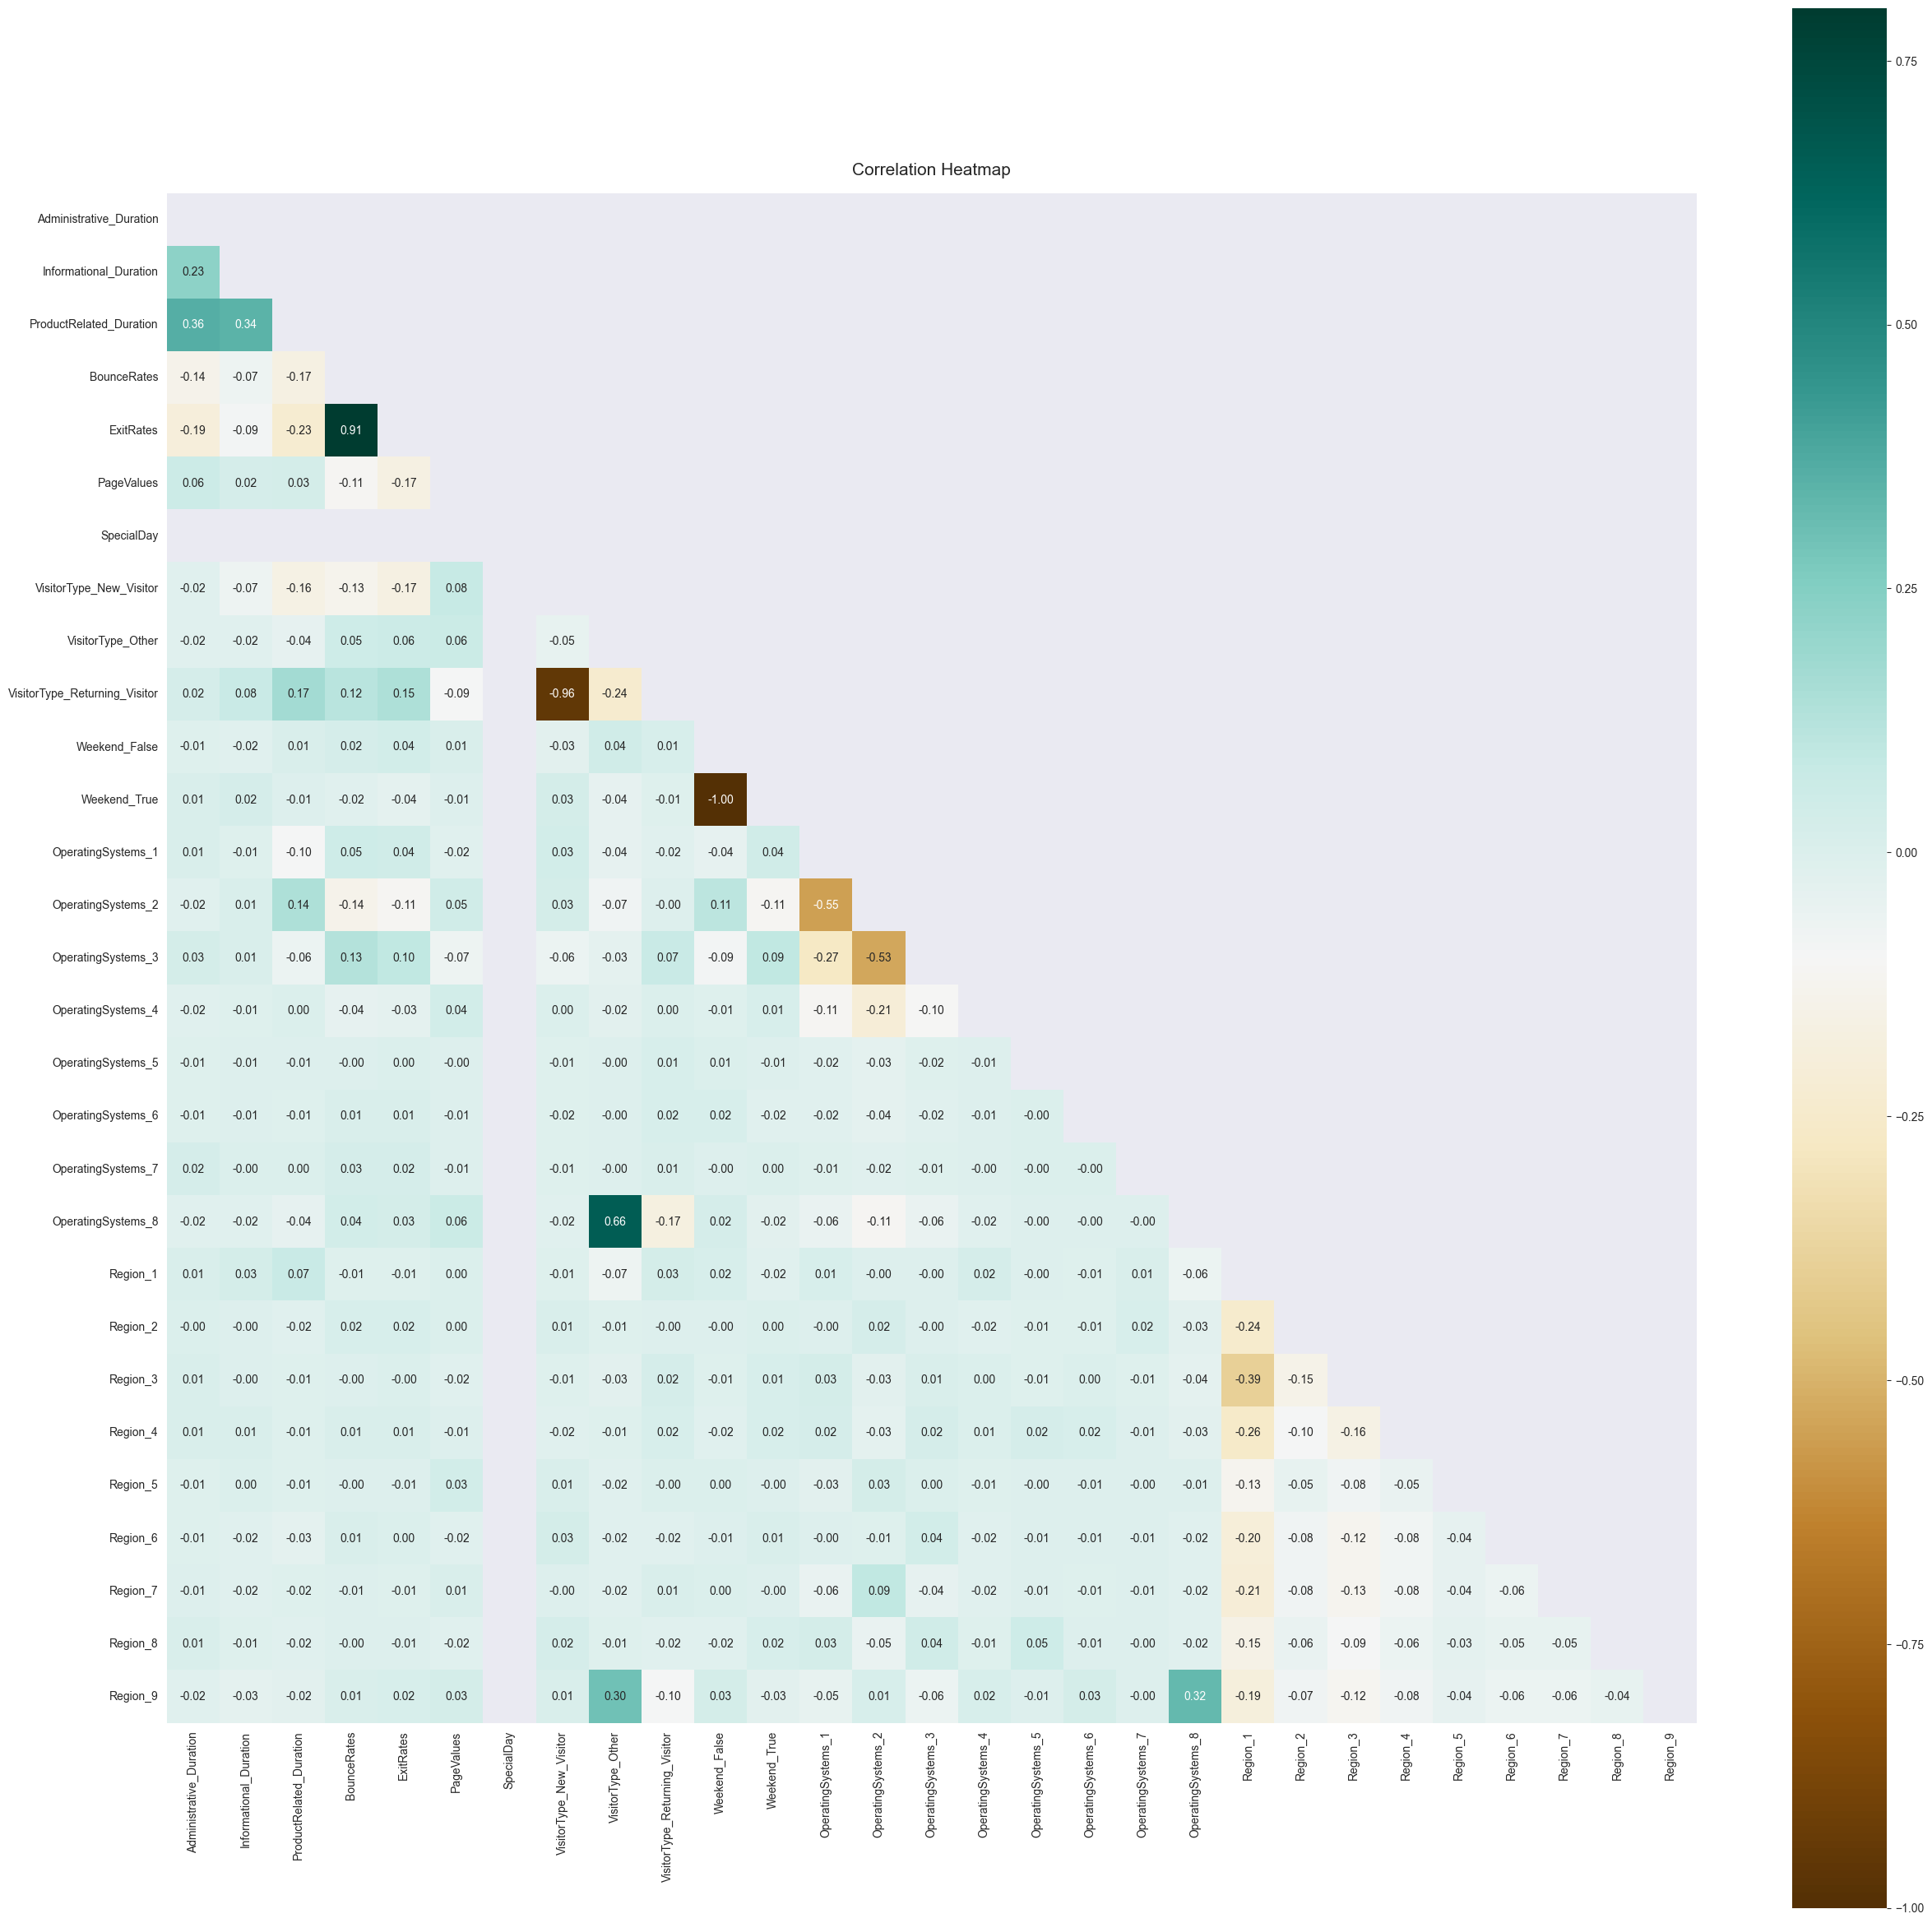

In [468]:
# Compute the correlation matrix and plot the triangular heatmap
corr = X_train_df.corr()
plt.figure(figsize=(30,30))
mask = np.triu(np.ones_like(corr, dtype=bool))
heatmap= sns.heatmap(corr, mask=mask, cmap='BrBG', vmax=.8, square=True, annot=True, fmt='.2f')
heatmap.set_title('Correlation Heatmap', fontsize=15, pad = 16)

This analysis suggests that some pairs of variables are correlated, and one of them among each pair should be dropped: the pair `'VisitorType_New_Visitor'` and `'VisitorType_Returning_Visitor'`, and the pair `'Weekend_true'` and '`Weekend_False`', and the pair `'ExitRates'` and `'BounceRates`'. The first two resulted from the one-hot encoding of the categorical variables, and the third pair resulted from the fact that the two variables are highly correlated.

In order to decide which variables to drop we compute the correlations with our target variable.

In [469]:
# Add the target variable to the dataframe
X_train_df['Revenue'] = np.asarray(y_train)
# Compute the correlation with respect to the target variable
X_train_df.corr()[['Revenue']].sort_values(by='Revenue', ascending=False)
# Drop the target variable from the dataframe
X_train_df.drop('Revenue', axis=1, inplace=True)


We  conclude from the correlation between the target variable and the rest of the variables that many of them are negligibly correlated with the target variable, therefore we drop the ones with a correlation coefficient smaller in absolute value than 0.05:

`'Region_1', 'Region_2', 'OperatingSystems_4', 'Weekend_True', 'OperatingSystems_7', 'OperatingSystems_8', 'Region_5', 'OperatingSystems_5', 'VisitorType_Other', 'Region_7', 'Region_4', 'Weekend_False', 'Region_9', 'Region_6', 'Region_8'`.

Most of these variables resulted from the one-hot encoding and can be grouped, which implies that the region, operating systems or the weekday of the visit is less relevant for the analysis, except in a few cases. From the pair correlation analysis we did before we conclude that the `'VisitorType_Returning_Visitor'` variable can be dropped because it is highly correlated with `'VisitorType_New_Visitor'`

In [470]:
drop_cols = ['Region_1', 'Region_2', 'OperatingSystems_4', 'Weekend_True', 'OperatingSystems_7', 'OperatingSystems_8', 'Region_5', 'OperatingSystems_5', 'VisitorType_Other', 'Region_7', 'Region_4', 'Weekend_False', 'Region_9', 'Region_6', 'Region_8', 'VisitorType_Returning_Visitor']

In [471]:
X_train_df['SpecialDay'].value_counts()

0.0    6875
Name: SpecialDay, dtype: int64

The variable `'SpecialDay'` has constant value in the train set, so it has no predictive value and should be dropped in both the train and test sets.

In [472]:
drop_cols.append('SpecialDay')
X_train_df.drop(drop_cols, axis=1, inplace=True)
X_test_df.drop(drop_cols, axis=1, inplace=True)

X_train_df.shape, X_test_df.shape


((6875, 12), (2091, 12))

In [473]:
X_train_df.head()

,Administrative_Duration,Informational_Duration,ProductRelated_Duration,BounceRates,ExitRates,PageValues,VisitorType_New_Visitor,OperatingSystems_1,OperatingSystems_2,OperatingSystems_3,OperatingSystems_6,Region_3
0,0.000000,0.0,0.003245,0.0,0.039683,0.000000,0.0,0.0,1.0,0.0,0.0,0.0
1,0.011828,0.0,0.003144,0.0,0.100000,0.000000,1.0,0.0,1.0,0.0,0.0,0.0
2,0.018654,0.0,0.001882,0.0,0.000000,0.116908,1.0,1.0,0.0,0.0,0.0,1.0
3,0.181851,0.0,0.020979,0.0,0.021930,0.077587,1.0,0.0,1.0,0.0,0.0,0.0
4,0.000000,0.0,0.000109,0.0,0.500000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0


In [474]:
X_test_df.head()

,Administrative_Duration,Informational_Duration,ProductRelated_Duration,BounceRates,ExitRates,PageValues,VisitorType_New_Visitor,OperatingSystems_1,OperatingSystems_2,OperatingSystems_3,OperatingSystems_6,Region_3
0,0.0,0.0,0.000000,1.00,1.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.001000,0.00,0.50,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,1.00,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000042,0.25,0.70,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.009809,0.10,0.25,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Model Fitting and Analysis

We will now fit a logistic regression model to the data and evaluate its performance.

In [475]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, accuracy_score as accuracy, recall_score as recall,  precision_score as precision,  f1_score, classification_report)
# Fit the model
lr_model = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000, class_weight='balanced').fit(X_train_df, y_train)
lr_pred = lr_model.predict(X_test_df)

Next, we report the performance of the model on the test set, using the confusion matrix and the classification metrics.

In [476]:
#print(confusion_matrix(y_test, lr_pred))

In [477]:
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

       False       0.98      0.91      0.95      1896
        True       0.49      0.82      0.61       195

    accuracy                           0.90      2091
   macro avg       0.74      0.86      0.78      2091
weighted avg       0.93      0.90      0.91      2091



In [478]:
print("accuracy:", accuracy(y_test, lr_pred))
print("precision:", precision(y_test, lr_pred))
print("recall:", recall(y_test, lr_pred))
print("f1 score:", f1_score(y_test, lr_pred))

accuracy: 0.9043519846963175
precision: 0.49226006191950467
recall: 0.8153846153846154
f1 score: 0.6138996138996139


Next we instantiate, fit and evaluate a gradient boosting classifier model.

In [479]:
from sklearn.ensemble import GradientBoostingClassifier

gbt_model = GradientBoostingClassifier(random_state=0, max_depth=5, n_estimators=100, learning_rate=0.1, max_features=None)
gbt_model.fit(X_train_df, y_train)
gbt_pred = gbt_model.predict(X_test_df)

In [480]:
print(classification_report(y_test, gbt_pred))

              precision    recall  f1-score   support

       False       0.97      0.97      0.97      1896
        True       0.71      0.68      0.69       195

    accuracy                           0.94      2091
   macro avg       0.84      0.82      0.83      2091
weighted avg       0.94      0.94      0.94      2091



**Final analysis of the results of the classification models**

It is clear that the two models predict better the class `Revenue == False` than the class `Revenue == True`, this is probably due to the fact that our data is imbalanced. The Gradient Boosted Tree performs better than the logistic regression model.

The usefulness of the model results then depends on the purpose of the analysis and the cost of each kind of misclassification (False Positives vs False Negatives). For example, if it is done to retain customers then the model will be less useful because it is not identifying well the visits that led to revenue. On the other hand, if the model is being used to identify new customers then it will be more useful because it is able to identify them more accurately.

### Customer Segmentation

For the second task we will generate clusters according to the purchase behavior of the entries in the complete dataset. We begin by checking the correlations again on the complete dataset to decide which variables to keep.

Text(0.5, 1.0, 'Correlation Heatmap')

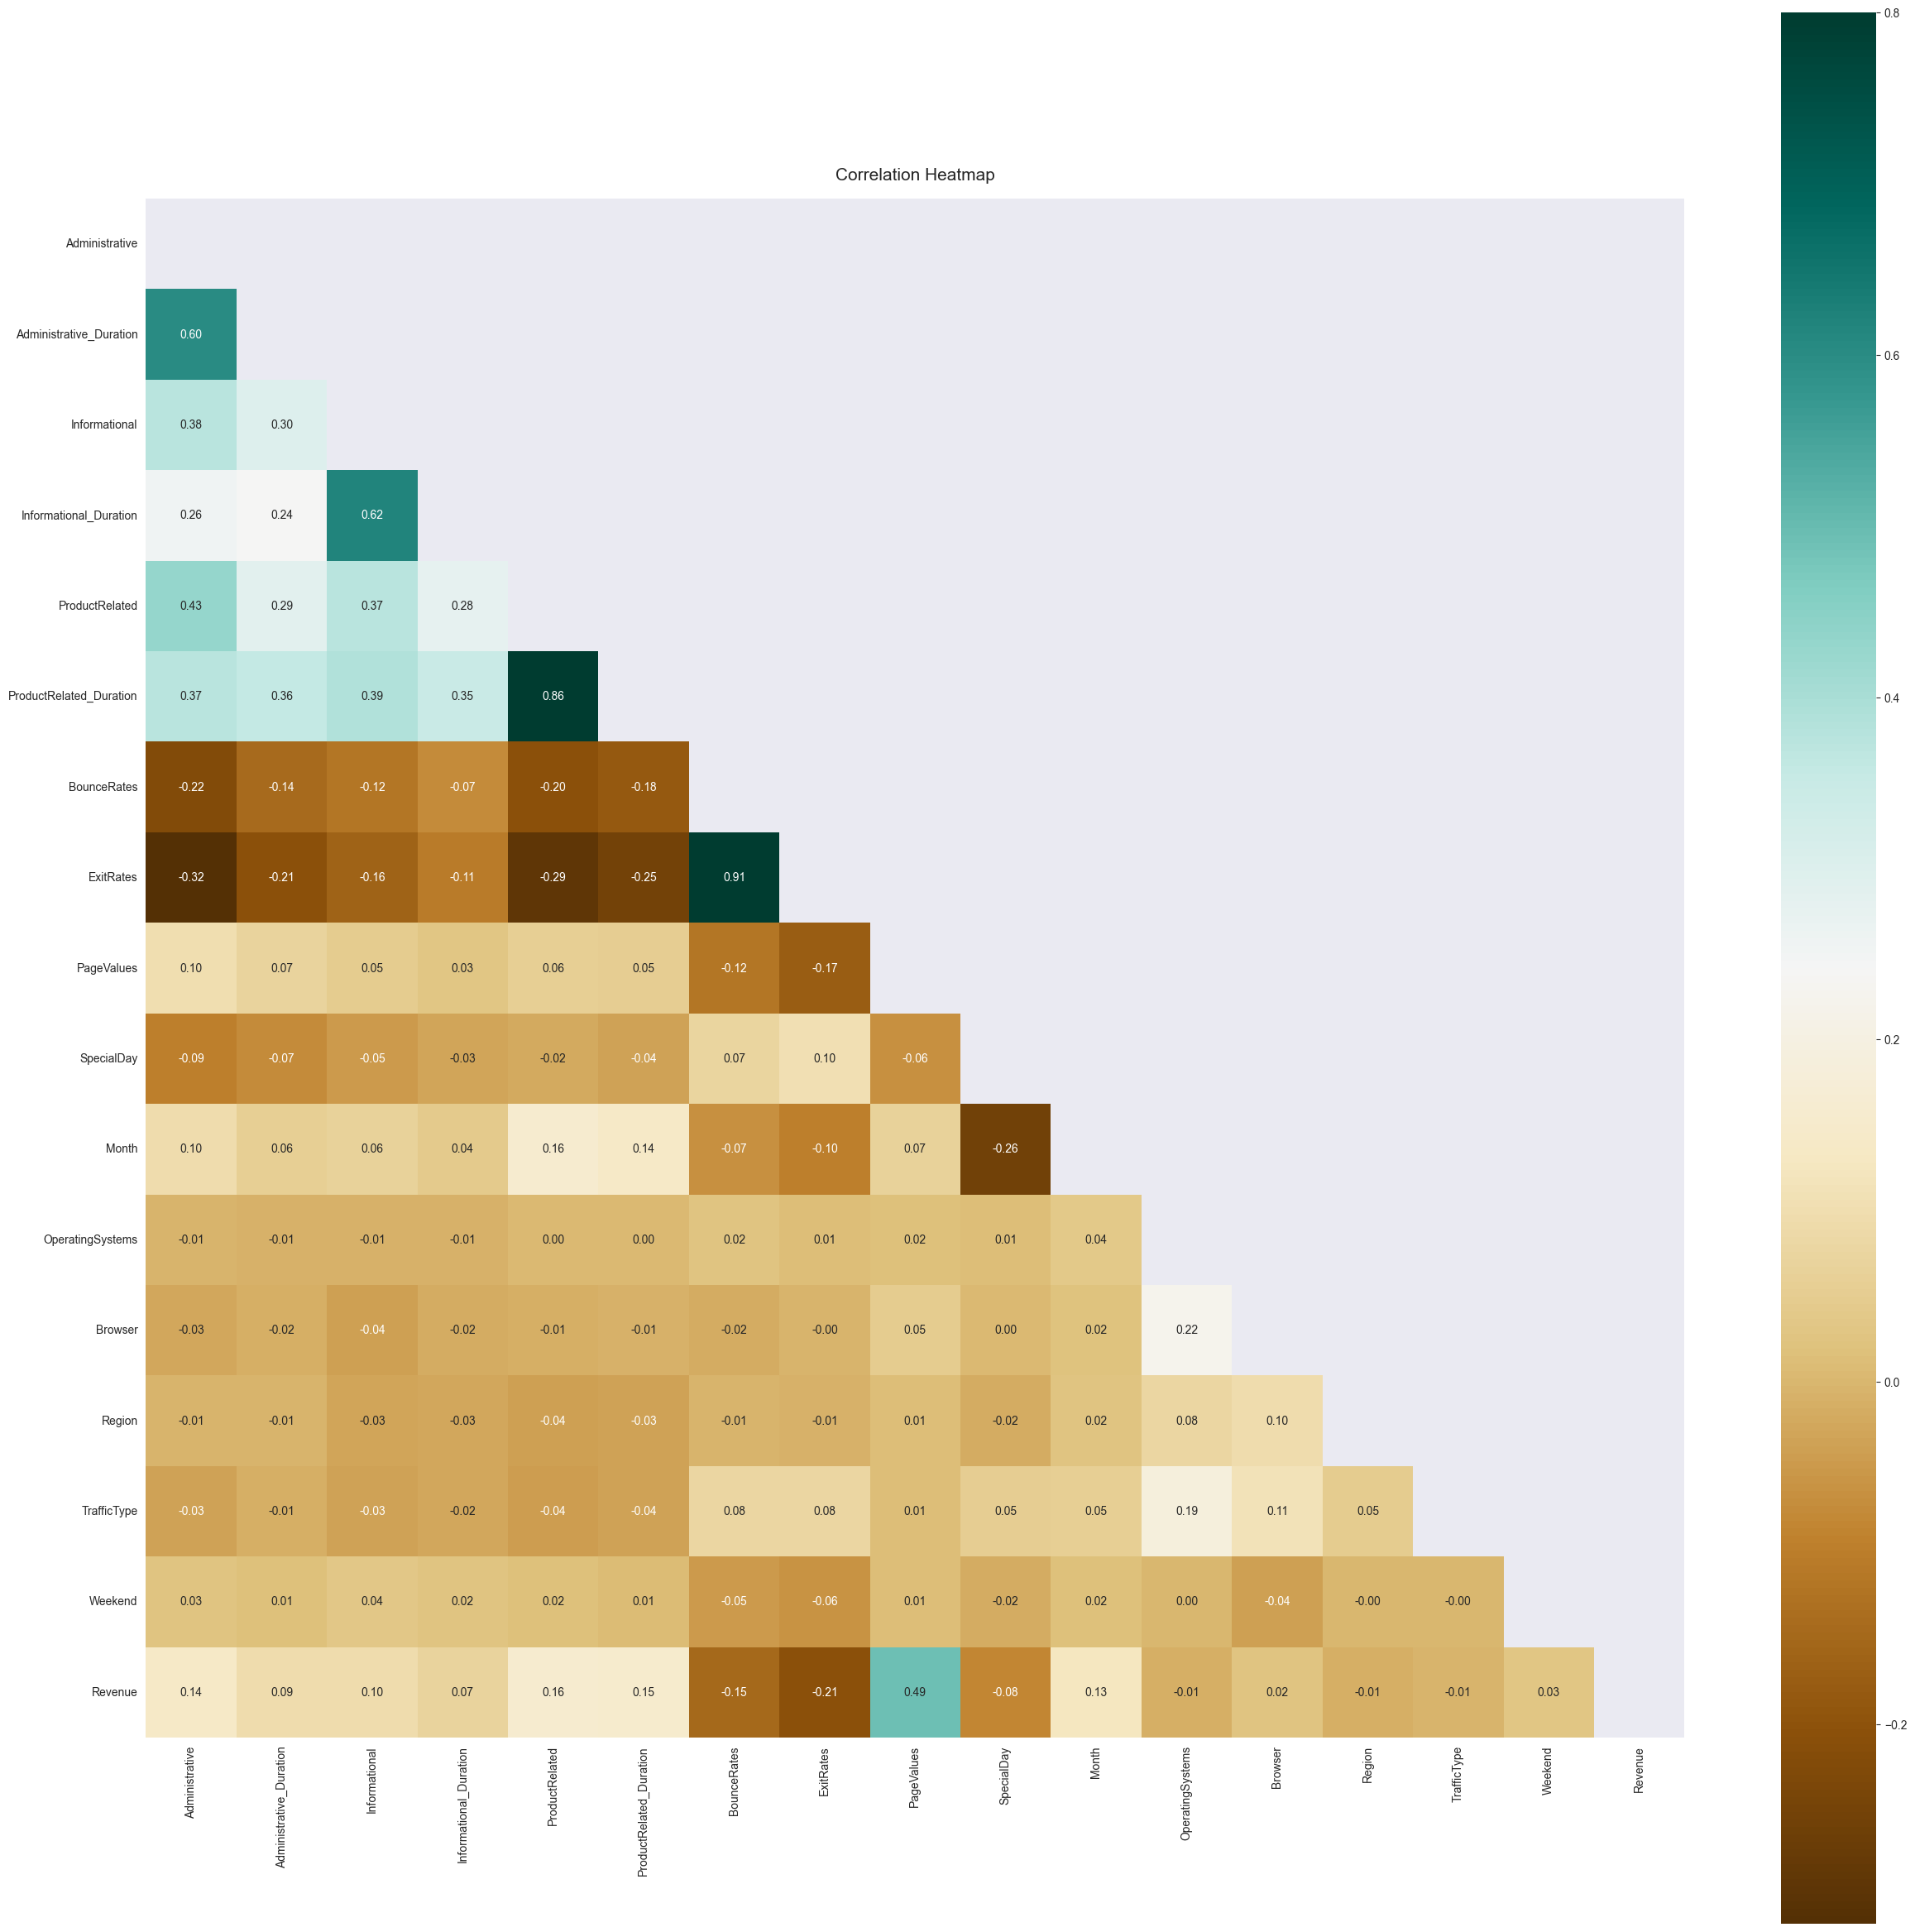

In [481]:
# Compute the correlation matrix and plot the triangular heatmap
corr_all = data.corr()
plt.figure(figsize=(30,30))
mask = np.triu(np.ones_like(corr_all, dtype=bool))
sns.heatmap(corr_all, mask=mask, cmap='BrBG', vmax=.8, square=True, annot=True, fmt='.2f')
plt.title('Correlation Heatmap', fontsize=15, pad = 16)

We have a high correlation between `'Administrative_Duration'` and `'Administrative'` and `'ProductRelated_Duration'` and `'Product_Related'` and also `'Informational_Duration'` and `'Informational'`, and between `'BounceRates'` and `'ExitRates'`. From the first three pairs we  drop the variables with discrete values (`'Administrative'`, `'Product_Related', 'Informational'`). We decided not to drop either `'BounceRates'` or `'ExitRates'` based on the description and analysis [here](https://cxl.com/guides/bounce-rate/bounce-rate-vs-exit-rate/) since they are both relevant and different measures for understanding online shopping behavior.

In [482]:
drop_cols = ['Administrative', 'ProductRelated', 'Informational']
ohe_cols = ['VisitorType', 'Weekend', 'Month', 'Revenue', 'Weekend']
numeric_cols = ['Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues','SpecialDay']
discrete_cols = ['OperatingSystems', 'Region', 'Browser']

assert len(drop_cols) + len(ohe_cols) + len(numeric_cols) + len(discrete_cols) == len(data.columns)

# Drop columns
data.drop(drop_cols, axis=1, inplace=True)

# One-hot encode categorical variables
data_transf = pd.get_dummies(data, columns =  ohe_cols)
data_transf.shape

(12330, 30)

# Dimensionality reduction

Since we will apply clustering algorithms and the number of features is large, we will first do dimensionality reduction using PCA. The aim is to reduce the number of features to a manageable number while retaining about 80% of the variance.


In [483]:
# Dimensionality reduction using PCA

# Apply Standard Scaler (needed before PCA)
scaler = StandardScaler()
data_sc = scaler.fit_transform(data_transf)
pca =  PCA(n_components=0.75, whiten = True)
data_pca = pca.fit_transform(data_sc)

data_pca.shape

(12330, 14)

In [484]:
print(pca.explained_variance_ratio_)
sum(pca.explained_variance_ratio_*100)

[0.13531828 0.09990916 0.06966477 0.06215389 0.05700252 0.05499855
 0.04376077 0.04016    0.03722887 0.03605216 0.03517741 0.0346223
 0.03455322 0.03431798]


77.49198795572295

We have then reduced the number of features to about 80% of the original number of features while retaining 77% of the variance, which is a good number to use for clustering algorithms. We now apply the K-means algorithm to the reduced dataset.

In [485]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [486]:
def visualize_elbow(X, ks):
    fig, ax = plt.subplots()
    inertias = [0]*len(ks)
    for index, k in enumerate(ks):
        kmeans = KMeans(n_clusters=k, random_state=10).fit(X)
        inertias[index] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    plt.plot(ks, inertias/np.max(np.asarray(inertias)))
    plt.xticks(ks)
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow plot')

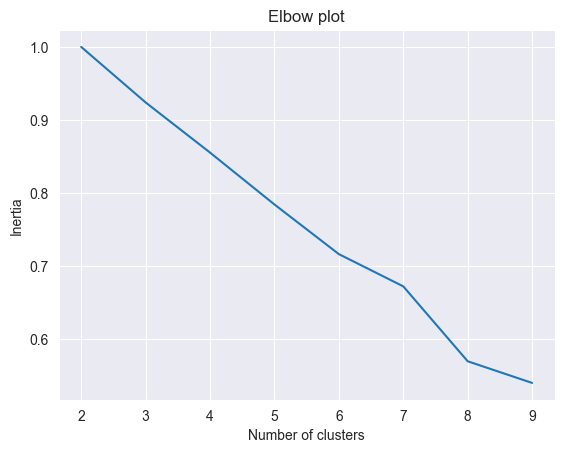

In [487]:
ks = range(2,10)
visualize_elbow(data_pca, ks)

It is very hard to decide a number of clusters based only on the elbow plot. We will then try with the Silhouette method.

For n_clusters = 2 The average silhouette_score is : 0.059765570919580374
For n_clusters = 3 The average silhouette_score is : 0.29708507292214126
For n_clusters = 4 The average silhouette_score is : 0.208605494605205
For n_clusters = 5 The average silhouette_score is : 0.17724039600286762
For n_clusters = 6 The average silhouette_score is : 0.17970266141962268
For n_clusters = 7 The average silhouette_score is : 0.2296035083937451
For n_clusters = 8 The average silhouette_score is : 0.29483425742128727


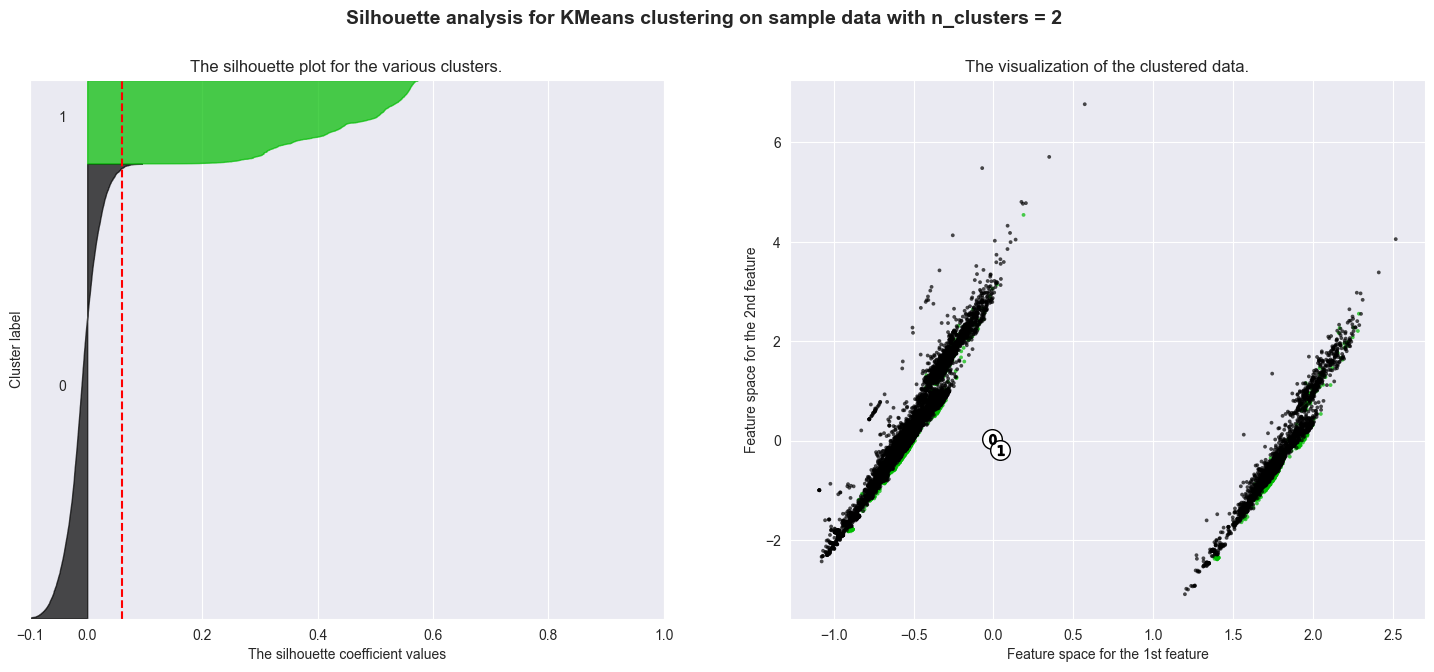

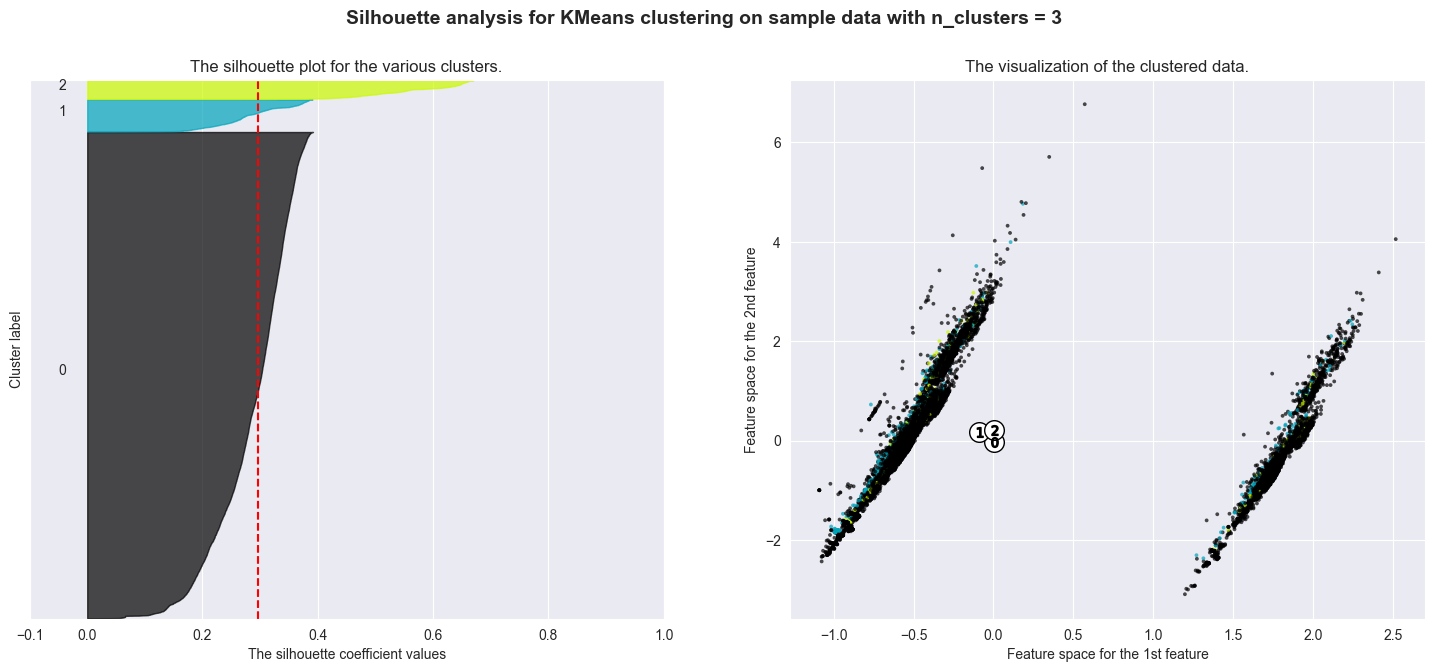

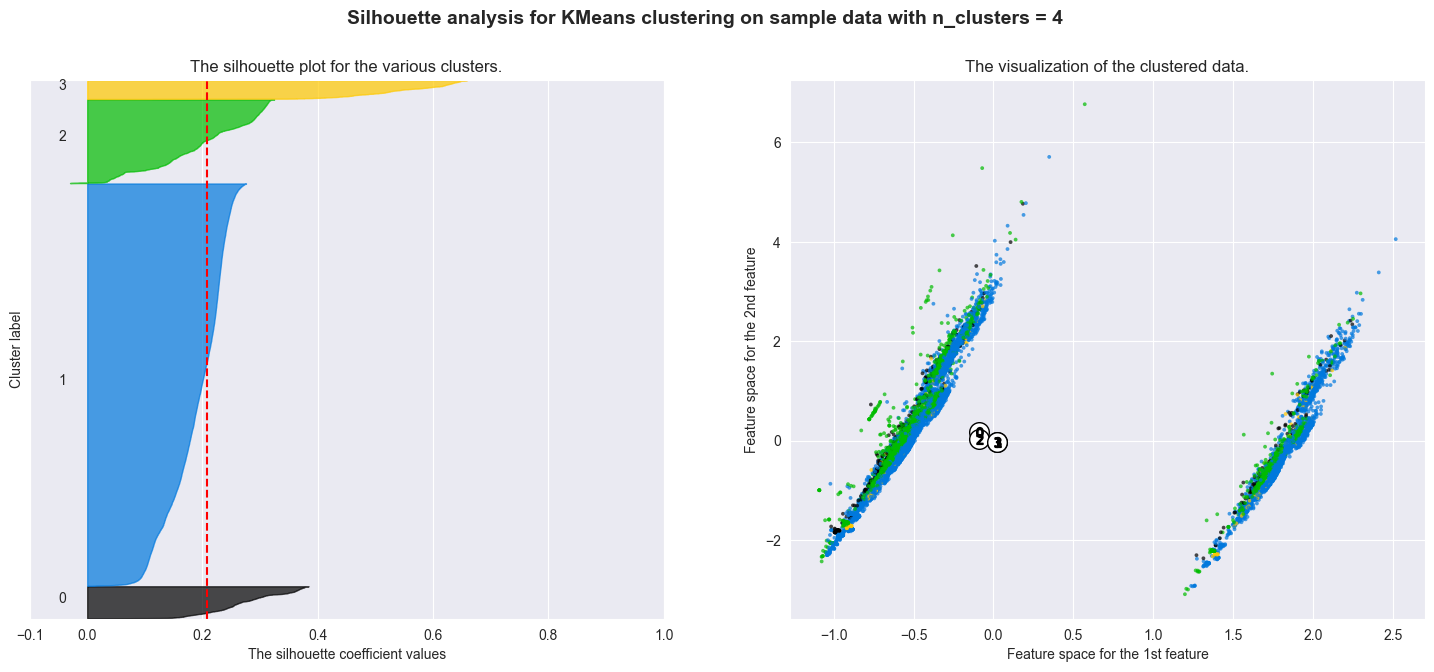

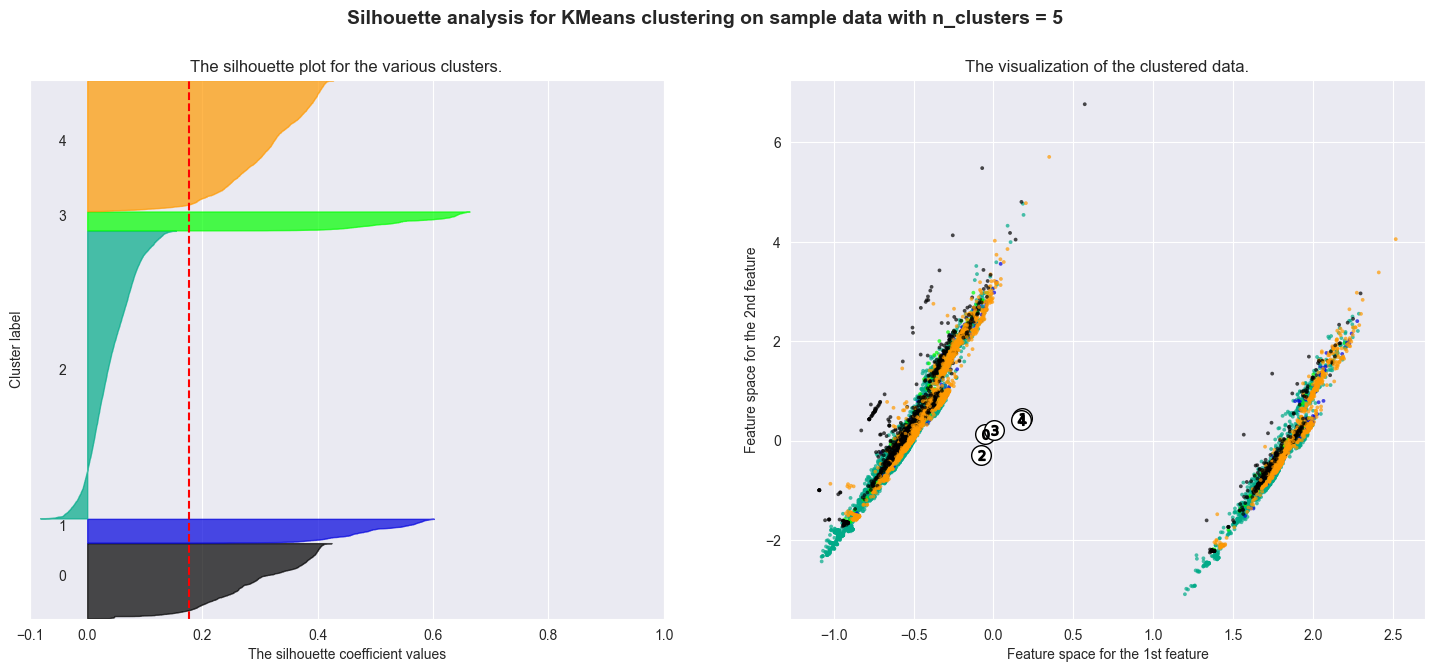

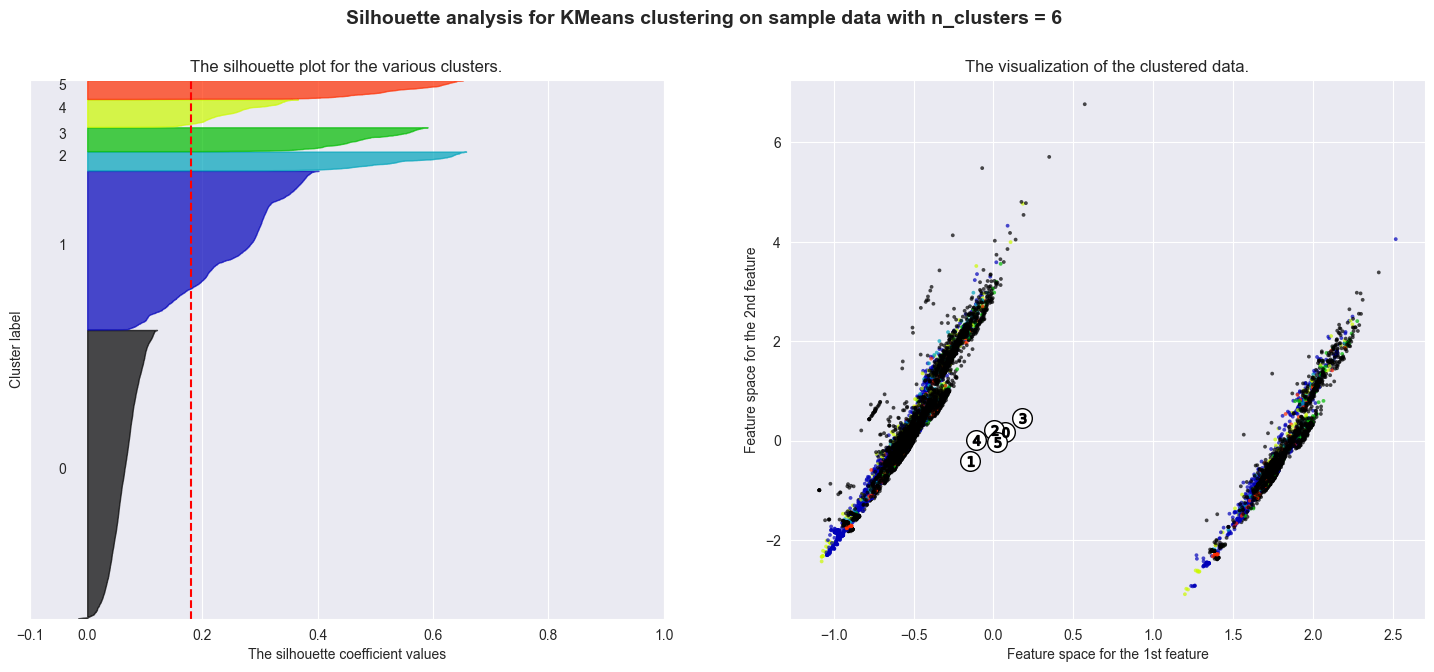

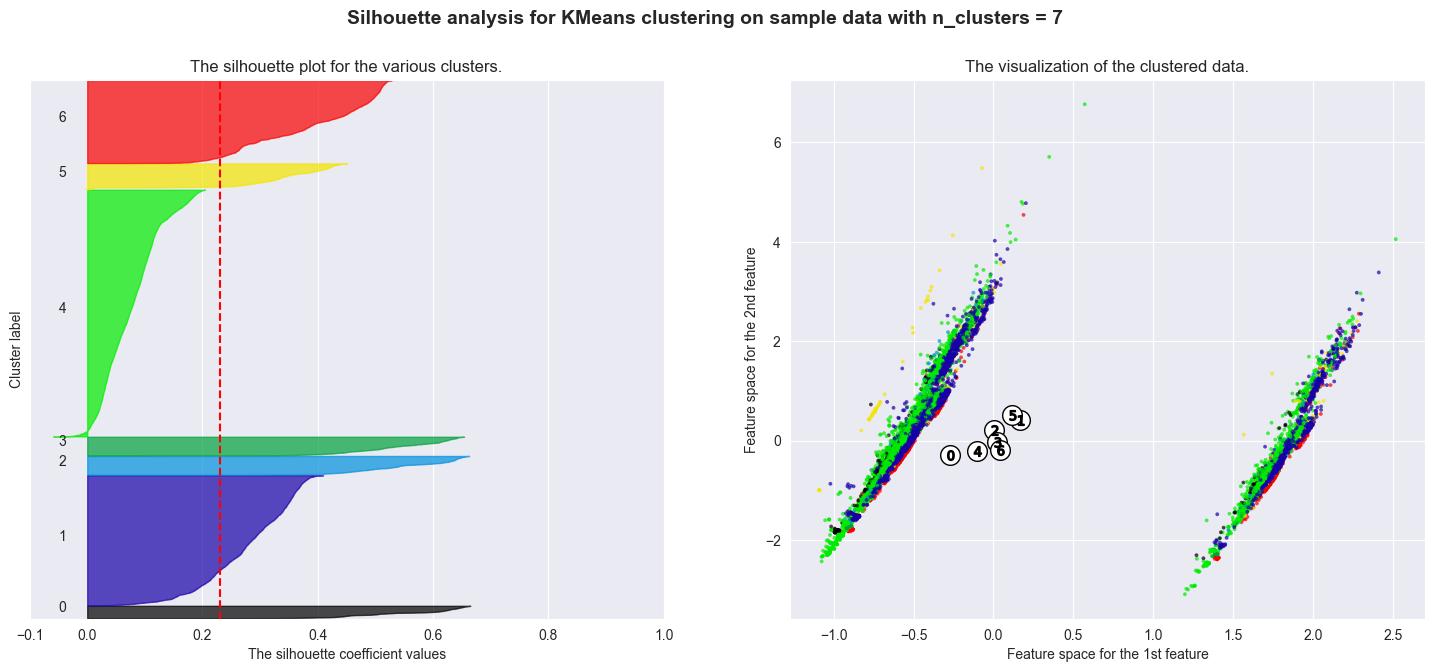

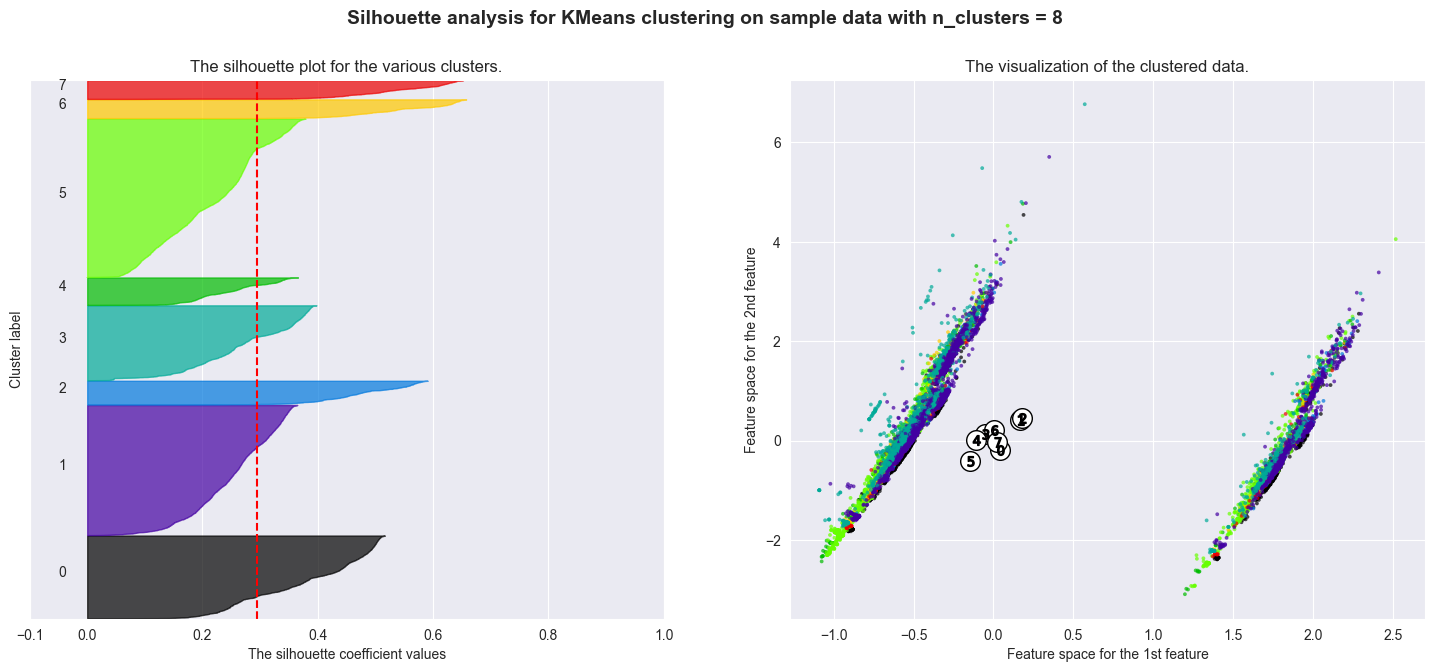

In [488]:
from utils import visualize_silhouette
visualize_silhouette(8, np.asarray(data_pca))


We choose to use 3 clusters, since k=3 has the highest silhouette score. We then apply the K-means algorithm to the reduced dataset. Next, we create a new dataframe to summarize some information on the clusters.

In [489]:
km = KMeans(n_clusters=3, random_state=10)
km.fit(data_pca)

# We add the cluster labels to the dataframe
data['km_cluster'] = km.predict(data_pca)
data['km_cluster'].value_counts()


cluster_info = pd.DataFrame(km.labels_, columns = ['km_cluster']).value_counts().reset_index().rename(columns = {0:'cluster_size'})

cluster_info['VisitsRevenue'] = data.groupby('km_cluster')['Revenue'].sum()
cluster_info['%VisitsRevenue'] = cluster_info['VisitsRevenue']/cluster_info['cluster_size']

cluster_info


,km_cluster,cluster_size,VisitsRevenue,%VisitsRevenue
0,0,11161,1717,0.153839
1,1,736,115,0.156250
2,2,433,76,0.175520


In [490]:
data.groupby('km_cluster')['Revenue'].sum()

km_cluster
0    1717
1     115
2      76
Name: Revenue, dtype: int64

In terms of the number of visits, the first cluster has the highest number of visits and the second cluster has the lowest number of visits. In terms of revenue, the percentage of revenue that is generated by the third cluster is larger than the percentage of revenue generated by the other two. We now examine more closely the clusters, in terms of which behavior is common in each cluster.

In [491]:
clusters_revenue = data[data['Revenue'] == True].groupby('km_cluster')
clusters_revenue.describe()



Administrative_Duration                                         \
                             count        mean         std  min       25%   
km_cluster                                                                  
0                           1717.0  120.814300  201.010467  0.0  0.000000   
1                            115.0  101.247588  201.818558  0.0  5.166667   
2                             76.0  117.005310  203.708828  0.0  0.000000   

                                           Informational_Duration             \
                  50%         75%      max                  count       mean   
km_cluster                                                                     
0           53.500000  152.833333  2086.75                 1717.0  60.628222   
1           36.200000   97.950000  1660.30                  115.0  26.560041   
2           43.208333  138.150000  1415.50                   76.0  36.441316   

            ... Region      TrafficType                                     \
            ...    75%  max       count      mean       std  min  25%  50%   
km_cluster  ...                                                              
0           ...    4.0  9.0      1717.0  4.096680  4.076766  1.0  2.0  2.0   
1           ...    5.0  9.0       115.0  3.417391  3.184344  1.0  2.0  2.0   
2           ...    4.0  9.0        76.0  3.236842  2.687593  1.0  2.0  2.5   

                       
            75%   max  
km_cluster             
0           4.0  20.0  
1           4.0  20.0  
2           4.0  20.0  

[3 rows x 96 columns]

Next we aggregate the cluster information to understand the average user behavior in each cluster.

In [445]:
clusters_revenue.agg(SpecialDay_average = ('SpecialDay', 'mean'),
                     PageValues_average = ('PageValues', 'mean'),
                     OperatingSystems_average = ('OperatingSystems', 'unique'),
                     VisitorType_unique = ('VisitorType', 'unique'),
                     Weekday_unique = ('Weekend', 'unique'),
                     InfoDuration_average = ('Informational_Duration', 'mean'),
                     AdminDuration_average = ('Administrative_Duration', 'mean'),
                     ProductDuration_average = ('ProductRelated_Duration', 'mean'),
                     BounceRates_average = ('BounceRates', 'mean')
                     )

,SpecialDay_average,PageValues_average,OperatingSystems_average,VisitorType_unique,Weekday_unique,InfoDuration_average,AdminDuration_average,ProductDuration_average,BounceRates_average
km_cluster,,,,,,,,,
0,0.025743,27.585543,"[2, 1, 3, 4, 6, 7, 5, 8]","[Returning_Visitor, New_Visitor, Other]","[False, True]",60.628222,120.814300,1960.389405,0.005167
1,0.000000,24.327463,"[2, 4, 3, 1]","[New_Visitor, Returning_Visitor]","[False, True]",26.560041,101.247588,987.460217,0.004547
2,0.000000,24.456123,"[2, 3, 4, 1]","[Returning_Visitor, New_Visitor]","[False, True]",36.441316,117.005310,1319.229106,0.004849


We see that the times that user spend in each type of webpages are different in each cluster. The first group of users spent a longer time in the website and a much longer time on the webpages of the product. In contrast the ones in the second cluster only spent less than half of the time that the first group spends in the product webpages. The last group spends more time on administrative webpages than the second group and also more time on the product webpages than the second group.

We think there are three types of purchase behaviour: those who look for information and then go to the product webpage (well informed customers), those who don't look too much for information and  also don't spend too much time on the product webpage, and a third one who is similar to the first but also spend less time on the product webpage. Note also that only the first group of users has varied type of operating system and all three types of visitor. Here we conjecture that maybe one of the groups is formed by mobile users (the third) who are more likely to spend more time on the product webpage, and also more likely to result in a purchase.

### Semi-Supervised Learning

In the last part of the assignment, we will apply semi-supervised learning. We will assume that only the data from June to September has the `'Revenue'` feature.

First we will build a classification model using only the labeled data to predict the `'Revenue'` feature for the test data from February to March.

Next we will build a semi-supervised model to estimate the `'Revenue'` feature for the missing records from October to December and then fit a classifier. This classifier will then be tested on the data from February to March.

In [511]:
# Reload data
data = pd.read_csv('dat/online_shoppers_intention.csv.gz', compression='gzip')

# Converting categorical variables to dummy variables
X = pd.get_dummies(data, columns = ['Weekend', 'VisitorType'])

# Splitting the data into train (labeled, unlabeled) and test sets
X_train_labeled = X[X['Month'].isin(['Jun', 'Jul', 'Aug', 'Sep'])]
X_train_unlabeled = X[X['Month'].isin(['Oct', 'Nov', 'Dec'])]
X_test = X[X['Month'].isin(['Feb', 'Mar'])]

# Target variable
y_train_labeled = X_train_labeled['Revenue']
y_train_unlabeled = X_train_unlabeled['Revenue']
y_test = X_test['Revenue']

# Drop columns not necessary
X_train_labeled = X_train_labeled.drop(['Revenue', 'Month'], axis=1)
X_train_unlabeled = X_train_unlabeled.drop(['Revenue', 'Month'], axis=1)
X_test = X_test.drop(['Revenue', 'Month'], axis=1)


In [512]:
X_train_labeled.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend_False,Weekend_True,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
5460,3,152.600000,0,0.0,28,608.883333,0.009375,0.031250,19.827709,0.0,2,2,7,13,1,0,0,0,1
5462,0,0.000000,0,0.0,20,419.600000,0.038095,0.068254,0.000000,0.0,3,2,3,3,0,1,0,0,1
5466,0,0.000000,0,0.0,4,41.400000,0.075000,0.125000,0.000000,0.0,3,2,6,1,1,0,0,0,1
5468,17,180.133333,1,80.6,180,6512.010952,0.002646,0.012249,0.000000,0.0,2,2,1,3,1,0,0,0,1
5472,3,41.200000,0,0.0,7,942.800000,0.000000,0.030000,0.000000,0.0,1,1,4,5,1,0,1,0,0


In [513]:
X_train_unlabeled.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend_False,Weekend_True,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
5455,0,0.0,0,0.0,1,207.570248,0.0,0.007937,0.000000,0.0,2,2,1,5,1,0,0,0,1
5457,1,63.4,0,0.0,3,120.400000,0.0,0.000000,42.293068,0.0,1,1,3,3,1,0,1,0,0
5461,7,56.3,0,0.0,15,315.400000,0.0,0.011111,0.000000,0.0,2,2,1,2,1,0,1,0,0
5463,1,39.2,2,120.8,7,80.500000,0.0,0.010000,0.000000,0.0,3,2,4,2,0,1,1,0,0
5464,3,89.6,0,0.0,57,1721.906667,0.0,0.005932,204.007949,0.0,2,2,1,4,0,1,0,0,1


The discrete-categorical variables not transformed by `pd.getdummies` will be transformed using one-hot encoding.

In [535]:
cat_columns = ['OperatingSystems', 'Browser', 'Region', 'TrafficType']
num_columns = ['Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration', 'BounceRates',
               'ExitRates','PageValues','SpecialDay']

def classifier_train_fit(X_train, y_train, X_test, y_test, scale = True) -> None:
    """
    This function trains a classifier, fits it on the training set and prints a classification report
    of the predicion on the train set.
    """
    scaler = MinMaxScaler()
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

    # Scale the data if necessary
    if scale:
        preprocess = ColumnTransformer([('scaler', scaler, num_columns),('ohe', ohe, cat_columns)])
    else:
        preprocess = ColumnTransformer([('ohe', ohe, cat_columns)])

    # Create Pipeline
    pipeline = Pipeline([('preprocess', preprocess),
                         ('classifier', LogisticRegression(class_weight='balanced', random_state=10, max_iter=1500))])

    # Fit the pipeline
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(classification_report(y_test, y_pred))


classifier_train_fit(X_train_labeled, y_train_labeled, X_test, y_test, scale = True)

              precision    recall  f1-score   support

       False       0.97      0.84      0.90      1896
        True       0.34      0.78      0.47       195

    accuracy                           0.84      2091
   macro avg       0.65      0.81      0.69      2091
weighted avg       0.91      0.84      0.86      2091



For the second part we will use semi-supervised learning to estimate the `'Revenue'` feature for the missing records from October to December.

In [536]:
X_train = pd.concat([X_train_labeled, X_train_unlabeled])

The unlabeled data will have the value -1 in the target variable.

In [537]:
y_train = np.concatenate((y_train_labeled, np.full(y_train_unlabeled.shape,-1)))

In [538]:
X_train.shape, y_train.shape

((6587, 19), (6587,))

In [539]:
X_test.shape, y_test.shape

((2091, 19), (2091,))

In [540]:
X_train.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend_False,Weekend_True,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
5460,3,152.600000,0,0.0,28,608.883333,0.009375,0.031250,19.827709,0.0,2,2,7,13,1,0,0,0,1
5462,0,0.000000,0,0.0,20,419.600000,0.038095,0.068254,0.000000,0.0,3,2,3,3,0,1,0,0,1
5466,0,0.000000,0,0.0,4,41.400000,0.075000,0.125000,0.000000,0.0,3,2,6,1,1,0,0,0,1
5468,17,180.133333,1,80.6,180,6512.010952,0.002646,0.012249,0.000000,0.0,2,2,1,3,1,0,0,0,1
5472,3,41.200000,0,0.0,7,942.800000,0.000000,0.030000,0.000000,0.0,1,1,4,5,1,0,1,0,0


In [541]:
X_test.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend_False,Weekend_True,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,1,1,1,1,1,0,0,0,1
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,2,2,1,2,1,0,0,0,1
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,4,1,9,3,1,0,0,0,1
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,3,2,2,4,1,0,0,0,1
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,3,3,1,4,0,1,0,0,1


In [542]:
def label_spread(X, y, scale = True):
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
    scaler = MinMaxScaler()

    # Apply OneHotEncoder to categorical variables
    X_cat = ohe.fit_transform(X[cat_columns])
    new_cat_cols = ohe.get_feature_names(cat_columns)

    # Scale the numerical variables
    if scale:
        X_num = scaler.fit_transform(X[num_columns])
        new_num_cols = num_columns
    else:
        X_num = X[num_columns]
        new_num_cols = num_columns

    # Concatenate the numerical and categorical variables
    X_new = np.hstack((X_num, X_cat))

    label_spread_model = LabelSpreading(kernel='knn', n_neighbors=5, alpha=0.01)
    label_spread_model.fit(X_new, y)
    semi_sup_preds = label_spread_model.transduction_
    return semi_sup_preds



Next we will use the semi-supervised model with scaling to estimate the `'Revenue'` feature for the missing records from October to December.

In [543]:
semi_sup_preds = label_spread(X_train, y_train, scale = True)

/opt/anaconda3/envs/mleng-course/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[1 0 0 ... 0 0 0]


The variable semi_sup_preds contains all labels for the training data predicted by the semisupervised model and the variable yhat contains the labels predicted by the classifier on the training data.

In [544]:
semi_sup_preds.shape[0]

6587

With the labels predicted by the semisupervised model, we can now fit a logistic regression classifier on the training data and predict the labels for the test data.

In [545]:
cat_columns = ['OperatingSystems', 'Browser', 'Region', 'TrafficType']
num_columns = ['Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration', 'BounceRates',
               'ExitRates','PageValues','SpecialDay']

classifier_train_fit(X_train, semi_sup_preds, X_test, y_test, scale = True)

              precision    recall  f1-score   support

       False       0.97      0.81      0.88      1896
        True       0.28      0.73      0.40       195

    accuracy                           0.80      2091
   macro avg       0.62      0.77      0.64      2091
weighted avg       0.90      0.80      0.84      2091



The final model is a logistic regression classifier without scaling.

In [546]:
semi_sup_preds2 = label_spread(X_train, y_train, scale = False)
classifier_train_fit(X_train, semi_sup_preds2, X_test, y_test, scale = False)

/opt/anaconda3/envs/mleng-course/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

       False       0.94      0.69      0.80      1896
        True       0.16      0.58      0.25       195

    accuracy                           0.68      2091
   macro avg       0.55      0.64      0.53      2091
weighted avg       0.87      0.68      0.75      2091



We have then that the unscaled model performs worse than the scaled model. The semisupervised model  performed slightly worse, but not by much, than the model only using the labeled data. One can try another model, e.g. a different classifier from logistic regression to see if this improves the performance.